# Anthropogenic heat from vehicular traffic

This notebook is used to process population data, and ultimately produce the anthropogenic heat flux (AHF) from vehicular traffic for the Greater Los Angeles (LA) region.

In [2]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
#import requests
import geopandas as gpd
import pyproj
import shapely.geometry
import contextily as ctx
from matplotlib.ticker import FormatStrFormatter
import geofeather
import dask_geopandas as dgpd
import pyogrio
import folium
import numpy as np

In [70]:
# import link inventory (i.e. locations and atributes)
inv_path = '/Users/josephko/USC/Research/Anthropogenic Heat/adms/congestion_inv_all_distinct_links.csv'
link_inv_df = pd.read_csv(inv_path)
link_inv_gdf = gpd.GeoDataFrame(link_inv_df, 
                                geometry=gpd.points_from_xy(link_inv_df.start_location_lng, link_inv_df.start_location_lat))
link_inv_gdf.set_crs(crs='EPSG:4326', inplace=True)
link_inv_gdf

,link_id,agency,city,link_type,on_street,from_street,to_street,start_location_lng,start_location_lat,direction,postmile,num_lanes,geometry
0,760650,Caltrans-D7,NaN,HIGHWAY,I-110,AMADOR,NaN,-118.232562,34.075049,SOUTH,25.00,5,POINT (-118.23256 34.07505)
1,810997,Caltrans-D8,NaN,HIGHWAY,10,M 1.0 W/O 4th STREET,NaN,-117.635171,34.083132,EAST,4.16,4,POINT (-117.63517 34.08313)
2,4078-E,LADOT,NaN,ARTERIAL,AVIATION BL,CENTURY BL,NaN,-118.378845,33.945362,EAST,0.00,5,POINT (-118.37884 33.94536)
3,775068,Caltrans-D7,NaN,HIGHWAY,I-5,PIONEER,NaN,-118.082820,33.921239,SOUTH,5.25,3,POINT (-118.08282 33.92124)
4,120764,LADOT,NaN,ARTERIAL,JEFFERSON BL,PLAYA VISTA DR,NaN,-118.428847,33.973710,SOUTH,0.00,4,POINT (-118.42885 33.97371)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88253,816382,Caltrans-D8,NaN,HIGHWAY,10,CALIFORNIA ST.,NaN,-117.229799,34.066939,EAST,28.17,4,POINT (-117.22980 34.06694)
88254,40147,LADOT,NaN,ARTERIAL,LA TIJERA BL,SEPULVEDA BL,NaN,-118.397119,33.957073,NORTH,0.00,4,POINT (-118.39712 33.95707)
88255,801577,Caltrans-D8,NaN,HIGHWAY,215,BOX SPRINGS,NaN,-117.301111,33.949468,NORTH,30.60,4,POINT (-117.30111 33.94947)
88256,60180,LADOT,NaN,ARTERIAL,HAYVENHURST AV,VENTURA BL,NaN,-118.492955,34.157672,WEST,0.00,4,POINT (-118.49295 34.15767)


In [9]:
# export as shapefile 
link_inv_gdf.to_file('/Users/josephko/USC/Research/Anthropogenic Heat/adms/link_inv_gdf.shp')

/Users/josephko/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/4m/_rb2pz1d7jx9ywsn916lhr_c0000gn/T/ipykernel_8945/392666212.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  link_inv_gdf.to_file('/Users/josephko/USC/Research/Anthropogenic Heat/adms/link_inv_gdf.shp')


In [71]:
# import traffic count (volume) data
# NOTE: sample data used for now for a single day: 8/15/2016 
traffic_path = '/Users/josephko/USC/Research/Anthropogenic Heat/adms/volume_hourly_20160815_8am.csv'
traffic_df = pd.read_csv(traffic_path)
traffic_df

,link_id,volume
0,20190,30.0
1,52041,101.0
2,1212348,7.0
3,51330,109.0
4,111496,146.0
...,...,...
14635,90835,180.0
14636,112248,127.0
14637,50814,72.0
14638,111139,79.0


In [72]:
# create links inventory with no duplicates
link_inv_gdf_unique = link_inv_gdf.drop_duplicates(subset=['link_id'])

# merge traffic count data with link attribute inventory
merged_df = traffic_df.merge(link_inv_gdf_unique, on='link_id', how='left')
merged_gdf = gpd.GeoDataFrame(merged_df)

# # remove duplicate columns
# traffic_gdf = merged_gdf.drop(columns=['hour_local_y', 'volume_y'])

# # rename columns
# traffic_gdf.rename(columns={'hour_local_x':'hour_local', 'volume_x':'volume'}, inplace=True)

# # groupby to remove duplicates (choose first match)
# traffic_gdf = merged_gdf.groupy(

# # remove unnecessary columns (for now)
# traffic_gdf = merged_gdf.drop(columns=['agency', 'city', 'start_location_lng', 'link_type', 'num_lanes', 'direction', 'start_location_lat', 'postmile', 'on_street', 'from_street', 'to_street'])

# # drop duplicate rows
# traffic_gdf.drop_duplicates(inplace=True)
# traffic_gdf

In [73]:
merged_gdf

,link_id,volume,agency,city,link_type,on_street,from_street,to_street,start_location_lng,start_location_lat,direction,postmile,num_lanes,geometry
0,20190,30.0,LADOT,NaN,ARTERIAL,1ST ST,BROADWAY,NaN,-118.246326,34.054011,SOUTH,0.00,2,POINT (-118.24633 34.05401)
1,52041,101.0,LADOT,NaN,ARTERIAL,14TH ST,ALAMEDA ST,NaN,-118.239709,34.025574,WEST,0.00,3,POINT (-118.23971 34.02557)
2,1212348,7.0,Caltrans-D12,NaN,HIGHWAY,261,IRVINE RANCH TOLL,NaN,-117.772525,33.734772,SOUTH,2.24,1,POINT (-117.77253 33.73477)
3,51330,109.0,LADOT,NaN,ARTERIAL,LA BREA AV,OBAMA BL,NaN,-118.356393,34.021685,WEST,0.00,4,POINT (-118.35639 34.02168)
4,111496,146.0,LADOT,NaN,ARTERIAL,HARBOR FWY S/B RAMPS,REDONDO BEACH BL,NaN,-118.287046,33.893021,SOUTH,0.00,2,POINT (-118.28705 33.89302)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,90835,180.0,LADOT,NaN,ARTERIAL,DE SOTO AV VICTORY BL,BUSWAY,NaN,-118.589743,34.188422,EAST,0.00,4,POINT (-118.58974 34.18842)
14636,112248,127.0,LADOT,NaN,ARTERIAL,IMPERIAL HWY,VERMONT AV,NaN,-118.293165,33.931040,EAST,0.00,3,POINT (-118.29317 33.93104)
14637,50814,72.0,LADOT,NaN,ARTERIAL,18TH ST,MAPLE AV,NaN,-118.261480,34.030962,EAST,0.00,3,POINT (-118.26148 34.03096)
14638,111139,79.0,LADOT,NaN,ARTERIAL,DENKER AV,GAGE AV,NaN,-118.305820,33.982426,EAST,0.00,2,POINT (-118.30582 33.98243)


In [75]:
# Import los angeles county boundary
la_county_hoods = gpd.read_file('/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/la_bound_nbhd.geojson')

# filter out points outside of la county
# traffic_gdf = traffic_gdf.sjoin(la_county_hoods)
traffic_gdf = merged_gdf.sjoin(la_county_hoods)

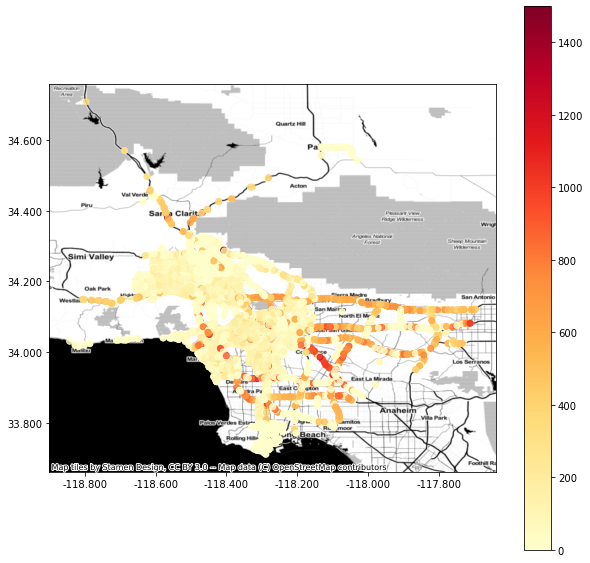

In [80]:
# visualize morning (8am) traffic 
# traffic_morning = traffic_gdf[traffic_gdf.hour_local == 8]
ax = traffic_gdf.plot(figsize=(10,10), column='volume', alpha=0.8, cmap='YlOrRd', 
                           vmin = 0, vmax = 1500, legend=True)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

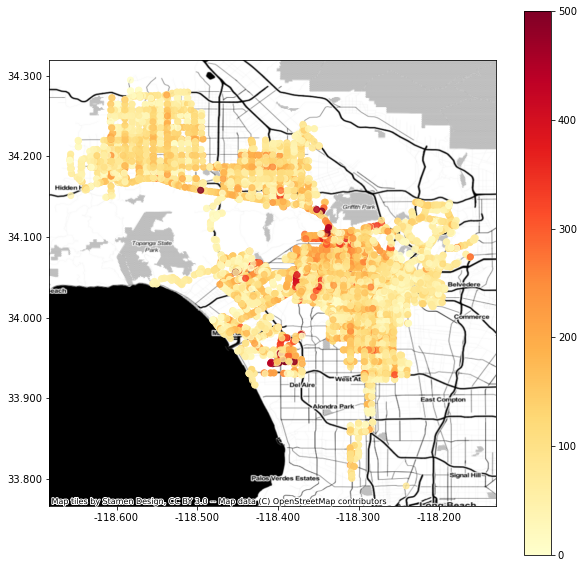

In [106]:
# visualize morning (8am) traffic in local roads only
traffic_local = traffic_gdf[(traffic_gdf.link_type == 'ARTERIAL') & (traffic_gdf.volume > 0)]
ax = traffic_local.plot(figsize=(10,10), column='volume', alpha=0.8, cmap='YlOrRd', 
                           vmin = 0, vmax = 500, legend=True)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

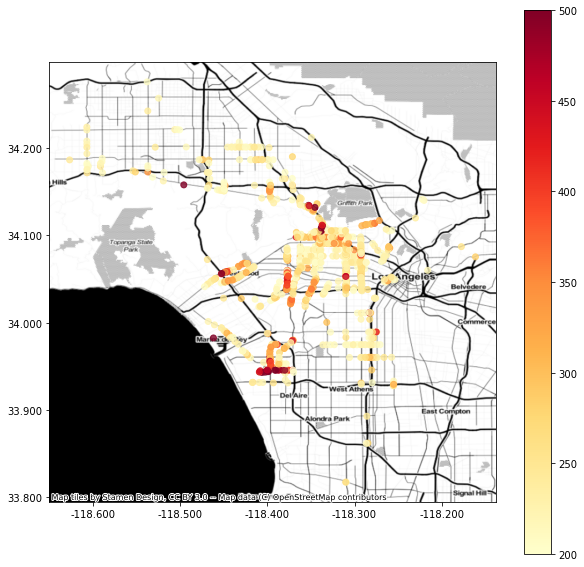

In [104]:
# visualize morning (8am) traffic in local roads only with more than 200/hr
traffic_local_heavy = traffic_gdf[(traffic_gdf.link_type == 'ARTERIAL') & (traffic_gdf.volume > 200)]
ax = traffic_local_heavy.plot(figsize=(10,10), column='volume', alpha=0.8, cmap='YlOrRd', 
                           vmin = 200, vmax = 500, legend=True)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

<AxesSubplot:>

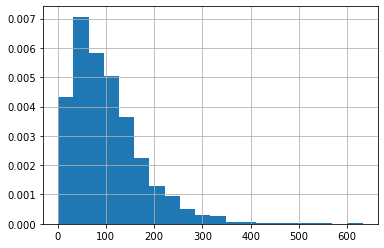

In [116]:
# arterial traffic volume distribution
arterial_hist = traffic_local.volume.hist(bins=20, density=True)
arterial_hist

<AxesSubplot:>

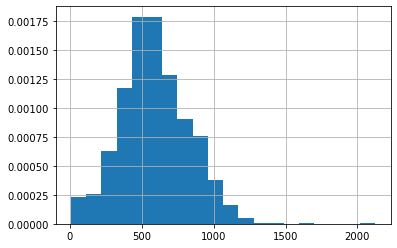

In [115]:
# highway traffic volume distribution
traffic_highway = traffic_gdf[(traffic_gdf.link_type == 'HIGHWAY') & (traffic_gdf.volume > 0)]
traffic_highway.volume.hist(bins=20, density=True)

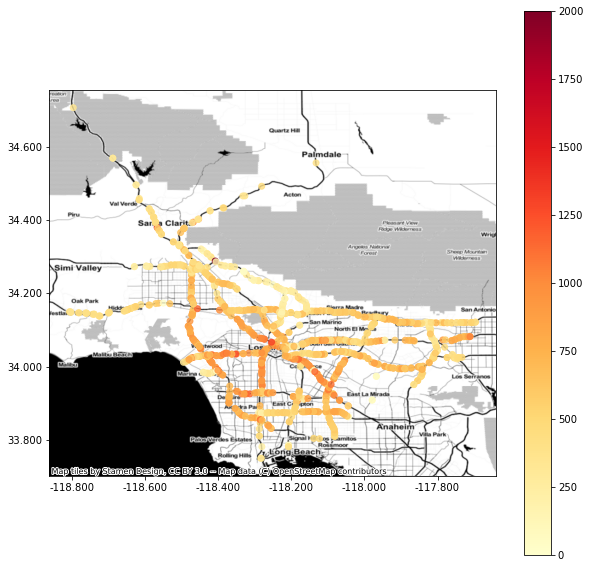

In [127]:
# visualize morning (8am) traffic in highways only]
ax = traffic_highway.plot(figsize=(10,10), column='volume', alpha=0.8, cmap='YlOrRd', 
                           vmin = 0, vmax = 2000, legend=True)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

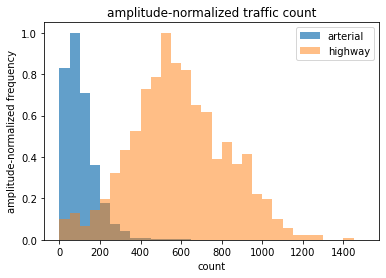

In [125]:
##computing the bin properties (same for both distributions)
num_bin = 30
bin_lims = np.linspace(0,1500,num_bin+1)
bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
bin_widths = bin_lims[1:]-bin_lims[:-1]

##computing the histograms
hist1, _ = np.histogram(traffic_local.volume, bins=bin_lims)
hist2, _ = np.histogram(traffic_highway.volume, bins=bin_lims)

##normalizing
hist1b = hist1/np.max(hist1)
hist2b = hist2/np.max(hist2)

fig, ax = plt.subplots(nrows = 1, ncols = 1)

ax.bar(bin_centers, hist1b, width = bin_widths, align = 'center', alpha=0.7, label='arterial')
ax.bar(bin_centers, hist2b, width = bin_widths, align = 'center', alpha = 0.5, label='highway')
ax.set_title('amplitude-normalized traffic count')
ax.set_xlabel('count')
ax.set_ylabel('amplitude-normalized frequency')
plt.legend()
plt.show()

In [139]:
# calculate median ratios 
median_arterial = traffic_local.volume.median()
median_highway = traffic_highway.volume.median()
median_ratio = median_arterial/median_highway
print('median_arterial/median_highway = ', median_ratio)

median_arterial/median_highway =  0.15130434782608695


Text(0, 0.5, 'count')

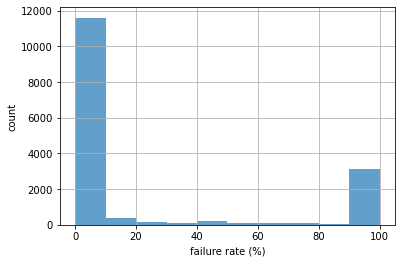

In [136]:
# histogram of failure rate for August, 2016
file_path = '/Users/josephko/USC/Research/Anthropogenic Heat/adms/failure_rate_2016_08.csv'
failure_rate = pd.read_csv(file_path)
failure_rate['failure_rate_percent'] = failure_rate.failure_rate*100
ax = failure_rate.failure_rate_percent.hist(bins=10, alpha=0.7)
ax.set_xlabel('failure rate (%)')
ax.set_ylabel('count')

## Test Case: Central LA w/ SCAG data

### Case 1: no connectors (only arterials and highways)

In [3]:
# import SCAG data 
scag_path = '/Users/josephko/USC/Research/Anthropogenic Heat/scag/scag_central_la_without_connectors.shp'
scag_gdf = gpd.read_file(scag_path)
scag_gdf

,ID,DIR,LENGTH,ROAD_NAME,ALT_NAME,ROUTE_NAME,ROUTE_NUMB,AB_FACILIT,BA_FACILIT,AB_POSTEDS,...,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type,geometry
0,12322,1,0.36,SANTA MONICA FWY,I 10,I10,10,10,NaN,65,...,None,1.66946888734,Pico-Union L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),pico-union,34.044161499124009,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (380745.624 3766992.531, 380788.683..."
1,12642,1,0.32,SANTA MONICA FWY,I 10,I10,10,10,NaN,65,...,None,1.66946888734,Pico-Union L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),pico-union,34.044161499124009,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (381042.036 3767005.678, 380529.293..."
2,12808,1,0.46,SANTA MONICA FWY,I 10,I10,10,10,NaN,65,...,None,1.66946888734,Pico-Union L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),pico-union,34.044161499124009,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (381331.884 3766991.693, 381362.564..."
3,13092,1,0.35,HOLLYWOOD FWY,101 FRWY,U101,101,10,NaN,55,...,None,2.71730553526,Westlake L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),westlake,34.062360999123754,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (381482.909 3771519.632, 381501.490..."
4,13316,1,0.34,SANTA MONICA FWY,I 10,I10,10,10,NaN,65,...,None,1.66946888734,Pico-Union L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),pico-union,34.044161499124009,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (381587.509 3767055.720, 381569.802..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,2766861,1,0.07,W 4TH ST,None,None,None,41,NaN,35,...,None,5.83816978008,Downtown L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),downtown,34.040008613525899,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (384396.499 3768582.811, 384489.562..."
1585,2766862,0,0.01,S GRAND AVE LOWER LEVEL,None,None,None,40,40.0,35,...,None,5.83816978008,Downtown L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),downtown,34.040008613525899,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (384396.499 3768582.811, 384406.247..."
1586,2766863,0,0.07,W GEN THAD KOSCIUSZKO WY,None,None,None,50,50.0,35,...,None,5.83816978008,Downtown L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),downtown,34.040008613525899,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (384597.694 3768835.544, 384692.727..."
1587,2766864,0,0.19,S GRAND AVE LOWER LEVEL,None,None,None,40,40.0,35,...,None,5.83816978008,Downtown L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),downtown,34.040008613525899,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (384406.247 3768594.892, 384597.694..."


<AxesSubplot:>

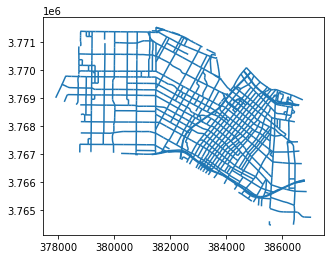

In [4]:
scag_gdf.plot()

In [16]:
sw.x

377906.1954266749

<AxesSubplot:>

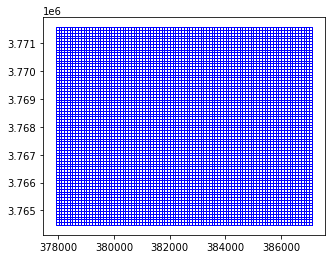

In [20]:
# create 100m grid around SCAG extent 

# create 2d grid
xmin, ymin, xmax, ymax = scag_gdf.total_bounds

# create a little buffer for extent
xmin = xmin - 0.005
ymin = ymin - 0.005
xmax = xmax + 0.005
ymax = ymax + 0.005

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((xmin, ymin))
ne = shapely.geometry.Point((xmax, ymax))

stepsize = 100 # grid resolution in meters

# # Set up transformers, EPSG:3857 is metric, same as EPSG:900913
# to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
# to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# # Project corners to target projection
# transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
# transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# Project corners to target projection (no transform needed) 
transformed_sw = [sw.x, sw.y]
transformed_ne = [ne.x, ne.y]

# Iterate over 2D area
grid_cells = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        x1 = x + stepsize
        y1 = y + stepsize
        cell = shapely.geometry.box(x, y, x1, y1)
        grid_cells.append(cell)
        y += stepsize
    x += stepsize


grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=scag_gdf.crs)
grid.plot(facecolor="none", edgecolor='blue')

<AxesSubplot:>

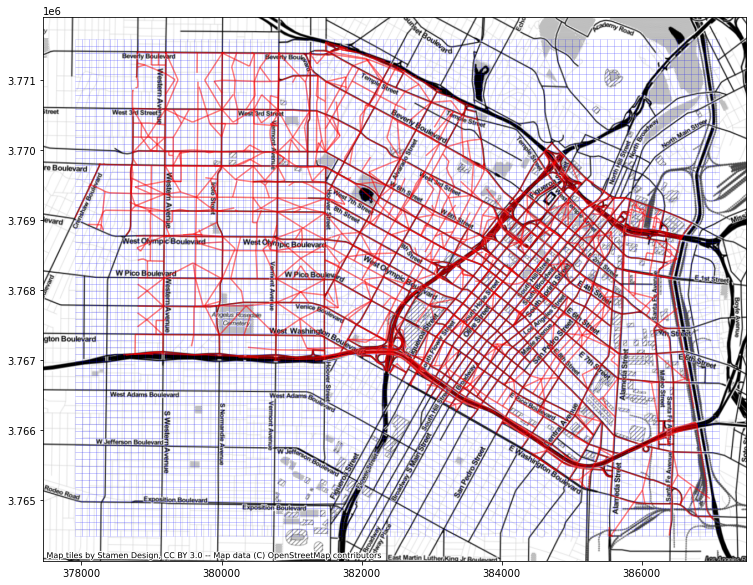

In [22]:
# visual check: plot grid over scag data
ax = scag_gdf.plot(figsize=(16,10), alpha=0.5, edgecolor='red')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=scag_gdf.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='blue', alpha = 0.1)

### Case 2: With connectors

In [5]:
# import SCAG data 
scag_path = '/Users/josephko/USC/Research/Anthropogenic Heat/scag/scag_central_la.shp'
scag_gdf = gpd.read_file(scag_path)
scag_gdf

,ID,DIR,LENGTH,ROAD_NAME,ALT_NAME,ROUTE_NAME,ROUTE_NUMB,AB_FACILIT,BA_FACILIT,AB_POSTEDS,...,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type,geometry
0,12322,1,0.36,SANTA MONICA FWY,I 10,I10,10,10,NaN,65,...,None,1.66946888734,Pico-Union L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),pico-union,34.044161499124009,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (380745.624 3766992.531, 380788.683..."
1,12642,1,0.32,SANTA MONICA FWY,I 10,I10,10,10,NaN,65,...,None,1.66946888734,Pico-Union L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),pico-union,34.044161499124009,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (381042.036 3767005.678, 380529.293..."
2,12808,1,0.46,SANTA MONICA FWY,I 10,I10,10,10,NaN,65,...,None,1.66946888734,Pico-Union L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),pico-union,34.044161499124009,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (381331.884 3766991.693, 381362.564..."
3,12984,1,0.36,None,None,None,None,80,NaN,50,...,None,1.66946888734,Pico-Union L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),pico-union,34.044161499124009,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (381610.005 3767075.180, 381590.829..."
4,13092,1,0.35,HOLLYWOOD FWY,101 FRWY,U101,101,10,NaN,55,...,None,2.71730553526,Westlake L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),westlake,34.062360999123754,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (381482.909 3771519.632, 381501.490..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,2766864,0,0.19,S GRAND AVE LOWER LEVEL,None,None,None,40,40.0,35,...,None,5.83816978008,Downtown L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),downtown,34.040008613525899,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (384406.247 3768594.892, 384597.694..."
2580,2767281,1,0.04,None,None,None,None,81,NaN,35,...,None,5.83816978008,Downtown L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),downtown,34.040008613525899,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (385820.723 3768865.924, 385818.241..."
2581,2767282,1,0.19,I 10 HOV,DIAMOND LANE,I10H,10,10,NaN,65,...,None,5.83816978008,Downtown L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),downtown,34.040008613525899,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (385849.607 3768880.436, 385851.539..."
2582,2767375,0,0.06,None,None,None,None,999,999.0,25,...,None,5.83816978008,Downtown L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),downtown,34.040008613525899,None,L.A. County Neighborhood (Current),segment-of-a-city,"LINESTRING (385764.823 3768930.259, 385849.607..."


<AxesSubplot:>

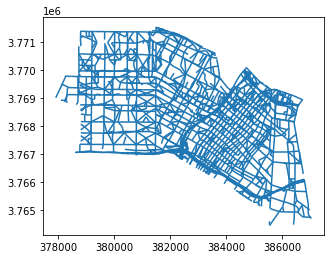

In [6]:
scag_gdf.plot()